In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt

### Device and Transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

### Load Models

In [3]:
# ResNet
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)
resnet.load_state_dict(torch.load("resnet_facial_hair_binary.pt"))
resnet.to(device).eval()

# EfficientNet
effnet = EfficientNet.from_name('efficientnet-b0')
effnet._fc = nn.Linear(effnet._fc.in_features, 2)
effnet.load_state_dict(torch.load("efficientnet_facial.pt"))
effnet.to(device).eval()

# YOLO
yolo_model = YOLO("best_hairnet.pt")

c:\anaconda\envs\mv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\envs\mv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Inference Functions

In [4]:
def predict_facial_hair(img, alpha=0.6):
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        r_out = torch.softmax(resnet(img_tensor), dim=1)
        e_out = torch.softmax(effnet(img_tensor), dim=1)
        combined = (1 - alpha) * r_out + alpha * e_out
        _, pred = torch.max(combined, 1)
    return pred.item()  # 0 = No Beard, 1 = Beard

def detect_hairnet(img_path):
    results = yolo_model.predict(source=img_path, conf=0.25, save=False, verbose=False)
    names = yolo_model.names
    detections = results[0].boxes.cls.cpu().numpy() if results[0].boxes else []
    detected_classes = [names[int(cls)] for cls in detections]
    return 'hairnet' in detected_classes

### Final Compliance Checker

In [5]:
def check_compliance(img_path):
    img = Image.open(img_path).convert("RGB")
    beard = predict_facial_hair(img) == 1
    hairnet = detect_hairnet(img_path)

    compliant = not beard and hairnet
    status = "Compliant" if compliant else "Non-Compliant"
    summary = f"[Beard: {'Yes' if beard else 'No'} | Hairnet: {'Yes' if hairnet else 'No'}] => {status}"

    # Display result
    plt.imshow(img)
    plt.title(summary)
    plt.axis('off')
    plt.show()


### Test One Image

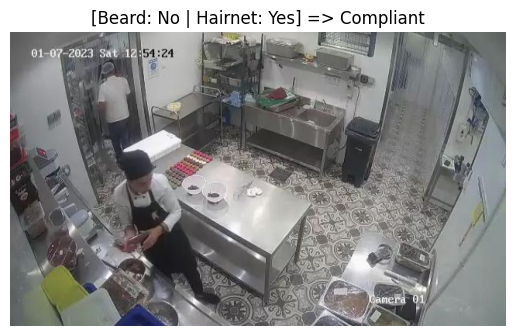

In [9]:
img_path = "dataset/hairnet/valid/images/Frame_12_802_329_jpg.rf.d3e8c4199eee6abdc2369b3f1ce52651.jpg"
check_compliance(img_path)